# 模型预测

## 导入相应算法

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression  #线性回归
from sklearn.ensemble import RandomForestRegressor #随机森林回归
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR  #支持向量回归
import lightgbm as lgb #lightGbm模型
from xgboost import XGBRFRegressor

from sklearn.model_selection import train_test_split # 切分数据
from sklearn.metrics import mean_squared_error #评价指标

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings
warnings.filterwarnings('ignore')

## 加载数据

### 未降维数据

In [8]:
from xgboost import train


all_data=pd.read_csv("./data/processed_zhengqi_data2.csv")

cond=all_data['label']=="train"
train_data=all_data[cond]
train_data.drop(labels='label',axis=1,inplace=True)
X_train,X_valid,y_train,y_valid=train_test_split(train_data.drop(labels='target',axis=1),
                                                 train_data['target'],
                                                 test_size=0.2)
cond2=all_data['label']=="test"
test_data=all_data[cond2]
test_data.drop(labels=['label','target'],axis=1,inplace=True)


### 降维数据

In [9]:
train_data_pca=np.load("data/train_data_pca.npz")['X_train']
target_data_pca=np.load("data/train_data_pca.npz")["y_train"]

X_train_pca,X_valid_pca,y_train_pca,y_valid_pca=train_test_split(train_data_pca,target_data_pca,test_size=0.2)
test_data_pca=np.load("data/test_data_pca.npz")["X_test"]

## 定义绘制模型学习曲线函数
![25cv.png](https://fynotefile.oss-cn-zhangjiakou.aliyuncs.com/fynote/463/1644928443000/4757a1835a4f4d2ea084305874f7b980.png)

In [8]:
def plot_learning_curve(model,title,X,y,cv=None):
    train_sizes,train_scores,test_scores=learning_curve(model,X,y,cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # 训练数据得分可视化
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,color="r")
    # 测试数据得分可视化
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    # 画图设置
    plt.grid() # 网格线设置
    plt.legend(loc=0) # 图例设置
    # 标题标签设置
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    

## 多元线性回归建模预测

### 模型训练

In [9]:
## 降维数据建模验证
clf=LinearRegression()
clf.fit(X_train_pca,y_train_pca)
score=mean_squared_error(y_valid_pca,clf.predict(X_valid_pca))
print("LinearRegression:",score)##mse

LinearRegression: 0.09612963103083333


In [10]:
## 未降维数据建模验证
clf=LinearRegression()
clf.fit(X_train,y_train)
score=mean_squared_error(y_valid,clf.predict(X_valid))
print("LinearRegression:",score)

LinearRegression: 0.0914681697490892


### 绘制学习曲线

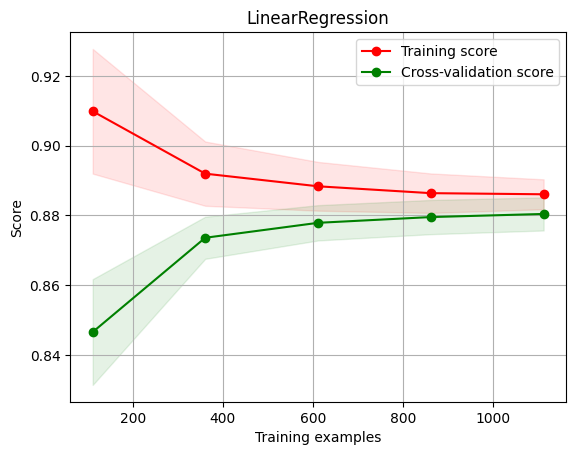

In [11]:
X = X_train_pca
y = y_train_pca
# 多元线性回归模型学习曲线图
title = "LinearRegression"
cv = ShuffleSplit(n_splits=100, test_size=0.5)
estimator = LinearRegression()    #建模
plot_learning_curve(estimator, title, X, y, cv = cv)

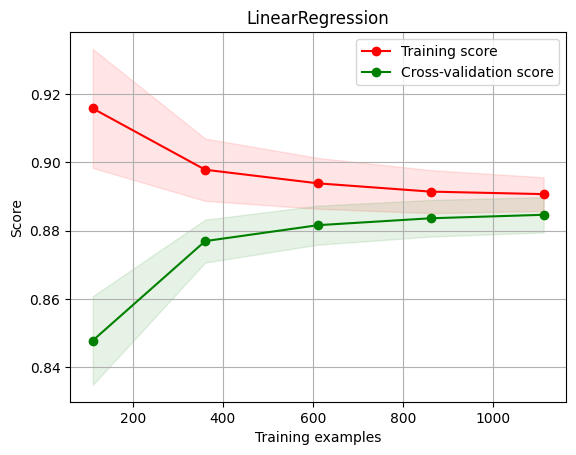

In [12]:
X=X_train
y=y_train
title="LinearRegression"
cv=ShuffleSplit(n_splits=100,test_size=0.5)
estimator=LinearRegression()
plot_learning_curve(estimator,title,X,y,cv)

### 模型预测

In [13]:
# 得分是：0.1598
model = LinearRegression()
model.fit(train_data_pca,target_data_pca)
y_ = model.predict(test_data_pca)
display(y_)
np.savetxt('./export_data/多元线性回归模型预测(降维数据).txt',y_)

array([ 0.18802274,  0.24611291, -0.1557421 , ..., -2.46741335,
       -2.51810503, -2.23076209], shape=(1925,))

In [14]:
# 得分是：0.1620
model = LinearRegression()
model.fit(train_data.drop('target',axis = 1),train_data['target'])
y_ = model.predict(test_data)
display(y_)
np.savetxt('./export_data/多元线性回归模型预测(非降维数据).txt',y_)

array([ 0.180302  ,  0.21599399, -0.17268982, ..., -2.44517796,
       -2.44884392, -2.06587572], shape=(1925,))

## 随机森林建模预测

### 模型训练

In [15]:
model = RandomForestRegressor(n_estimators=200, # 200棵树模型
                            max_depth= 10,
                            max_features = 'log2',# 构建树时，特征筛选量
                            min_samples_leaf=10,# 是叶节点所需的最小样本数
                            min_samples_split=40,# 是分割所需的最小样本数
                            criterion='squared_error')
model.fit(X_train_pca, y_train_pca)
score = mean_squared_error(y_valid_pca, model.predict(X_valid_pca))
print("随机森林:   ", score)

随机森林:    0.23228127224589182


In [16]:
model = RandomForestRegressor(n_estimators=200, # 200棵树模型
                            max_depth= 10,
                            max_features = 'log2',# 构建树时，特征筛选量
                            min_samples_leaf=10,# 是叶节点所需的最小样本数
                            min_samples_split=40,# 是分割所需的最小样本数
                            criterion='squared_error')
model.fit(X_train, y_train)
score = mean_squared_error(y_valid, model.predict(X_valid))
print("LinearRegression:   ", score)

LinearRegression:    0.0956270435826192


### 绘制学习曲线

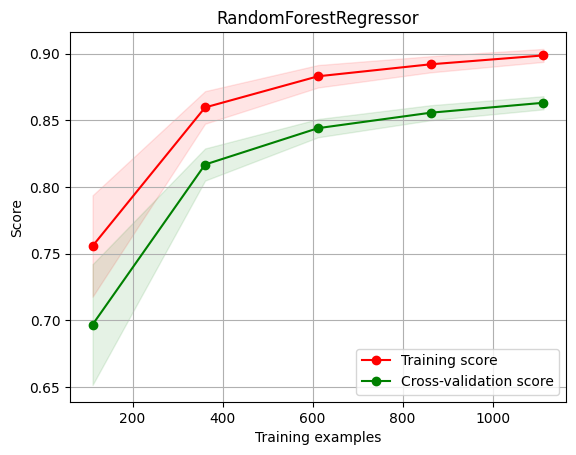

In [17]:
# 比较耗时：2min 45s
X = X_train
y = y_train
# 随机森林模型学习曲线图
title = "RandomForestRegressor"
cv = ShuffleSplit(n_splits=100, test_size=0.5)
model = RandomForestRegressor(n_estimators=200, # 200棵树模型
                            max_depth= 10,
                            max_features = 'log2',# 构建树时，特征筛选量
                            min_samples_leaf=10,# 是叶节点所需的最小样本数
                            min_samples_split=40,# 是分割所需的最小样本数
                            criterion='squared_error')
plot_learning_curve(model, title, X, y, cv = cv)
plt.savefig('./export_data/12-随机森林非降维数据学习曲线.png',dpi = 200)

### 模型预测

In [18]:
model =  RandomForestRegressor(n_estimators=200, # 200棵树模型
                            max_depth= 10,
                            max_features = 'log2',# 构建树时，特征筛选量
                            min_samples_leaf=10,# 是叶节点所需的最小样本数
                            min_samples_split=40,# 是分割所需的最小样本数
                            criterion='squared_error')
model.fit(train_data_pca,target_data_pca)
y_ = model.predict(test_data_pca)
display(y_)
np.savetxt('./export_data/随机森林模型预测(降维数据).txt',y_)

array([ 0.38563599,  0.34841483, -0.1047662 , ..., -1.04839508,
       -1.07735464, -1.08454406], shape=(1925,))

In [19]:
model = RandomForestRegressor(n_estimators=200, # 200棵树模型
                            max_depth= 10,
                            max_features = 'log2',# 构建树时，特征筛选量
                            min_samples_leaf=10,# 是叶节点所需的最小样本数
                            min_samples_split=40,# 是分割所需的最小样本数
                            criterion='squared_error')
model.fit(train_data.drop('target',axis = 1),train_data['target'])
y_ = model.predict(test_data)
display(y_)
np.savetxt('./export_data/随机森林模型预测(非降维数据).txt',y_)

array([ 0.30256265,  0.22456521, -0.04383847, ..., -2.34089793,
       -2.4209633 , -2.38964092], shape=(1925,))

## SVR支持向量机 

### 模型训练

In [20]:
model = SVR(kernel='rbf',C = 1,gamma=0.01,tol = 0.0001,epsilon=0.3)
model.fit(X_train_pca, y_train_pca)
score = mean_squared_error(y_valid_pca, model.predict(X_valid_pca))
print("SVR得分:   ", score)

SVR得分:    0.09775061277854678


In [21]:
model = SVR(kernel='rbf')
model.fit(X_train, y_train)
score = mean_squared_error(y_valid, model.predict(X_valid))
print("SVR得分:   ", score)

SVR得分:    0.23762839429167523


### 绘制学习曲线

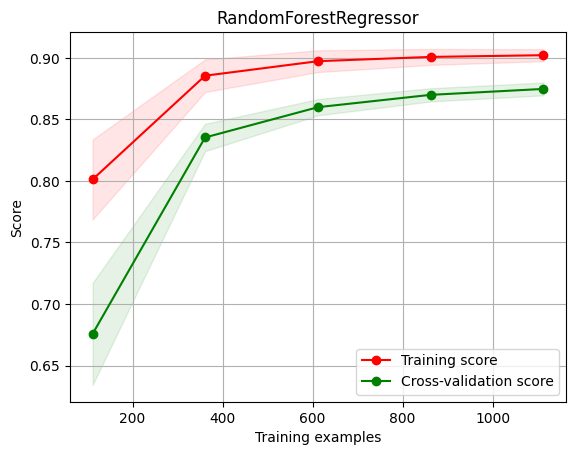

In [22]:
X = X_train_pca ##20.8s
y = y_train_pca
# 随机森林模型学习曲线图
title = "RandomForestRegressor"
cv = ShuffleSplit(n_splits=100, test_size=0.5)
model = SVR(kernel='rbf',C = 1,gamma=0.01,tol = 0.0001,epsilon=0.3)
plot_learning_curve(model, title, X, y, cv = cv)
plt.savefig('./export_data/15-SVR降维数据学习曲线.png',dpi = 200)

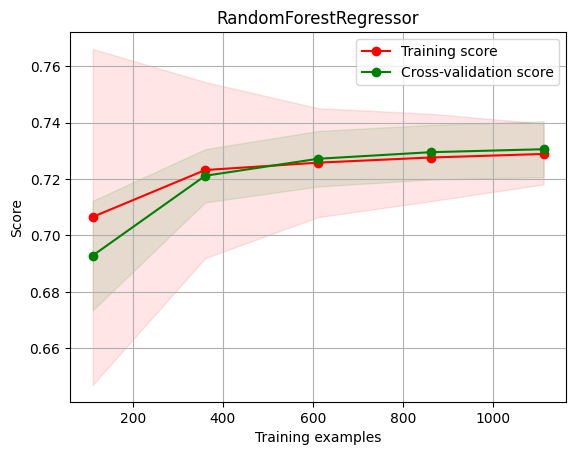

In [23]:
X = X_train ##49.3s
y = y_train
# 随机森林模型学习曲线图
title = "RandomForestRegressor"
cv = ShuffleSplit(n_splits=100, test_size=0.5)
model = SVR(kernel='rbf')
plot_learning_curve(model, title, X, y, cv = cv)
plt.savefig('./export_data/16-SVR非降维数据学习曲线.png',dpi = 200)

### 模型预测

In [24]:
model =  SVR(kernel='rbf',C = 1,gamma=0.01,tol = 0.0001,epsilon=0.3)
model.fit(train_data_pca,target_data_pca)
y_ = model.predict(test_data_pca)
display(y_)
np.savetxt('./export_data/SVR模型预测(降维数据).txt',y_)

array([ 0.26958642,  0.25920386, -0.10122391, ..., -2.22155225,
       -2.3239961 , -2.18865886], shape=(1925,))

In [25]:
model =SVR(kernel='rbf')
model.fit(train_data.drop('target',axis = 1),train_data['target'])
y_ = model.predict(test_data)
display(y_)
np.savetxt('./export_data/SVR模型预测(非降维数据).txt',y_)

array([ 0.02366046,  0.0795185 , -0.3815812 , ..., -3.27797957,
       -3.20270896, -3.10625782], shape=(1925,))

In [26]:
model =  SVR(kernel='poly')
model.fit(train_data_pca,target_data_pca)
y_ = model.predict(test_data_pca)
display(y_)
np.savetxt('./export_data/SVR-poly模型预测(降维数据).txt',y_)

array([ 0.20042313,  0.26680596,  0.14459824, ..., -4.66039099,
       -3.79414397, -2.76923448], shape=(1925,))

In [27]:
model =SVR(kernel='poly')
model.fit(train_data.drop('target',axis = 1),train_data['target'])
y_ = model.predict(test_data)
display(y_)
np.savetxt('./export_data/SVR--poly模型预测(非降维数据).txt',y_)

array([-0.07192709, -0.04480958, -0.21569895, ..., -0.45655652,
       -0.45623861, -0.45561885], shape=(1925,))

## GBDT梯度提升树

### 模型训练

#### 降维数据

In [28]:
model = GradientBoostingRegressor(learning_rate=0.03, # 学习率
                                loss='huber',  # 损失函数
                                max_depth=14, # 决策树深度
                                max_features='sqrt',# 节点分裂时参与判断的最大特征数
                                min_samples_leaf=10,# 是叶节点所需的最小样本数
                                min_samples_split=40,# 是分割所需的最小样本数
                                n_estimators=300,# 集成树数量
                                subsample=0.8)# 抽样比例
model.fit(X_train_pca, y_train_pca)
score = mean_squared_error(y_valid_pca, model.predict(X_valid_pca))
print("GBDT得分:   ", score)

GBDT得分:    0.11437758406544606


#### 非降维数据

In [29]:
model = GradientBoostingRegressor(learning_rate=0.03, # 学习率
                                loss='huber',  # 损失函数
                                max_depth=14, # 决策树深度
                                max_features='sqrt',# 节点分裂时参与判断的最大特征数
                                min_samples_leaf=10,# 是叶节点所需的最小样本数
                                min_samples_split=40,# 是分割所需的最小样本数
                                n_estimators=300,# 集成树数量
                                subsample=0.8)# 抽样比例
model.fit(X_train, y_train)
score = mean_squared_error(y_valid, model.predict(X_valid))
print("GBDT得分:   ", score)

GBDT得分:    0.07415863505196899


### 绘制学习曲线

#### 降维数据学习曲线

CPU times: user 11.9 s, sys: 52 ms, total: 12 s
Wall time: 12 s


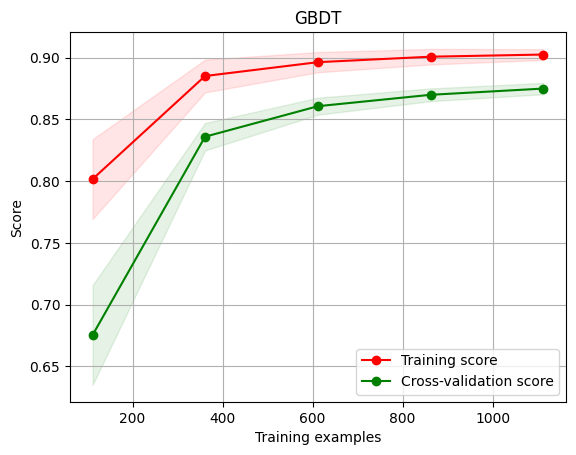

In [30]:
%%time
X = X_train_pca
y = y_train_pca
# 随机森林模型学习曲线图
title = "GBDT"
cv = ShuffleSplit(n_splits=100, test_size=0.5)
model = SVR(kernel='rbf',C = 1,gamma=0.01,tol = 0.0001,epsilon=0.3)
plot_learning_curve(model, title, X, y, cv = cv)
plt.savefig('export_data/17-GBDT降维数据学习曲线.png',dpi = 200)

### 模型预测

In [10]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
	n_estimators=200,
	max_depth=10,
	max_features='log2',  # 'auto' is deprecated, use 'sqrt' or 'log2'
	min_samples_leaf=10,
	min_samples_split=40,
	criterion='squared_error'
)
model.fit(train_data_pca, target_data_pca)
y_ = model.predict(test_data_pca)
display(y_)
np.savetxt('export_data/随机森林模型预测（降维数据）.txt', y_)

array([ 0.40913842,  0.37135688, -0.00663369, ..., -1.05782902,
       -1.05518978, -1.09792776], shape=(1925,))